In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt

# 读取数据
data = pd.read_csv('C:/MyProject/MIMIC-IPE/加了中介变量的数据集/用于特征选择的数据集.csv')

# Icu_total_hour列中有缺失值，用0填充
data['Icu_total_hour'].fillna(0, inplace=True)
# 移除LOHS_hrs列名中的“_”
data.rename(columns={'LOHS_hrs': 'LOHS'}, inplace=True)
data.rename(columns={'Icu_total_hour': 'LHIS'}, inplace=True)
# Lung Tumor列该名为Lung cancer
data.rename(columns={'Lung Tumor': 'Lung cancer'}, inplace=True)
# 查看data中所有的列名，并计算列中空值计数，赋值给一个dataframe
data_info = pd.DataFrame(data.columns, columns=['columns'])
data_info['null_count'] = [data[col].isnull().sum() for col in data.columns]
#%
# 特征列
feature_columns = [
    'Group', 'F.Hosp', 'DTI', 'FXaI', 'UFH', 'VKA', 'Age', 'Lung cancer', 'No TD', 'Non Solid Tumor',
     'OCD', 'PT', 'TTP', 'CAD', 'DM', 'HF', 'HTN', 'No CVD MD', 'PAD','LOHS','LHIS','Prostate cancer',
    'Stomach cancer',
    'Colorectal cancer',
    'Breast cancer'
]
# 'Other Solid Tumor',
# 提取特征和目标变量
X = data[feature_columns]

# 目标变量
y1_event = data['D31D']
y2_event = data['D60D']
y3_event = data['D90D']
y4_event = data['D180D']
y1_time = data['T.O.D_31d']
y2_time = data['T.O.D_60d']
y3_time = data['T.O.D_90d']
y4_time = data['T.O.D_180d']

C:\Users\ZhouNan\AppData\Local\Temp\ipykernel_6252\675362628.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Icu_total_hour'].fillna(0, inplace=True)


In [3]:
# 创建一个空的DataFrame，列是不同的时间点
lasso_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
lasso_feature = pd.DataFrame(index=X.columns)

def feature_selection(X, y_time, y_event):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的DataFrame
    df = pd.DataFrame(X_scaled, columns=X.columns)
    df['time'] = y_time
    df['event'] = y_event

    # 使用LASSO COX回归进行特征选择
    cph = CoxPHFitter(penalizer=0.1)  # L1正则化强度，可以调整以选择不同数量的特征
    cph.fit(df, duration_col='time', event_col='event')

    # 获取特征的重要性
    feature_importances = cph.summary['coef']

    # 返回特征重要性
    return feature_importances

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection(X, y_time, y_event)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    lasso_feature = lasso_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
lasso_df.loc['LASSO COX'] = group_importances

# 输出DataFrame
print(lasso_df)

# 输出所有目标变量的特征重要性
print(lasso_feature)


                 y1        y2        y3        y4
LASSO COX -0.078365 -0.067445 -0.095119 -0.103638
                         y1        y2        y3        y4
Age                0.151966  0.202733  0.230726  0.267707
Breast cancer      0.004321 -0.014916 -0.029583 -0.048040
CAD               -0.007625 -0.012050 -0.013224 -0.015348
Colorectal cancer -0.012337 -0.036494 -0.052689 -0.051645
DM                -0.023714 -0.017014 -0.006754 -0.033066
DTI                0.031178  0.042293  0.049095  0.026737
F.Hosp             0.061034  0.102434  0.119420  0.127951
FXaI               0.097090  0.112915  0.148279  0.166515
Group             -0.078365 -0.067445 -0.095119 -0.103638
HF                 0.054557  0.037318  0.023055  0.050966
HTN               -0.018699 -0.014308 -0.003928 -0.015000
LHIS               0.163944  0.123097  0.114503  0.090574
LOHS               0.080430  0.155495  0.148813  0.151036
Lung cancer        0.107585  0.068735  0.056334  0.040610
No CVD MD         -0.092775 -0

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import RandomSurvivalForest
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance

# 创建一个空的DataFrame，列是不同的时间点
rsf_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
rsf_feature = pd.DataFrame(index=X.columns)

def feature_selection_rsf(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的DataFrame
    y = np.array([(event, time) for event, time in zip(y_event, y_time)], dtype=[('event', 'bool'), ('time', 'float')])

    # 训练随机生存森林模型
    rsf = RandomSurvivalForest(n_estimators=100, min_samples_split=10, min_samples_leaf=15, random_state=random_seed)
    rsf.fit(X_scaled, y)

    # 使用置换重要性来计算特征重要性
    perm_importance = permutation_importance(rsf, X_scaled, y, n_repeats=10, random_state=random_seed)
    feature_importances = perm_importance.importances_mean

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
    feature_importance_df.set_index('Feature', inplace=True)

    return feature_importance_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_rsf = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_rsf(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_rsf.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    rsf_feature = rsf_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
rsf_df.loc['Random Survival Forest'] = group_importances_rsf

# 输出DataFrame
print(rsf_df)

# 输出所有目标变量的特征重要性
print(rsf_feature)


                              y1        y2        y3        y4
Random Survival Forest  0.007875  0.003661  0.004395  0.004377
                         y1        y2        y3        y4
Age                0.045993  0.041989  0.040992  0.040984
Breast cancer      0.000000  0.000000  0.000000  0.000000
CAD                0.000204  0.000102  0.000352  0.000074
Colorectal cancer  0.000000  0.000000  0.000000  0.000000
DM                 0.000313  0.000187  0.000198  0.000049
DTI                0.000000  0.000000  0.000000  0.000000
F.Hosp             0.006488  0.008877  0.009009  0.007674
FXaI               0.003484  0.003206  0.004965  0.005595
Group              0.007875  0.003661  0.004395  0.004377
HF                 0.001553  0.001988  0.000461  0.001441
HTN                0.002575  0.004737  0.002846  0.003814
LHIS               0.109506  0.074593  0.051044  0.039788
LOHS               0.067233  0.063038  0.048373  0.039114
Lung cancer        0.002927  0.001668  0.001156  0.001630
No C

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

# 创建一个空的DataFrame，列是不同的时间点
gbsa_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
gbsa_feature = pd.DataFrame(index=X.columns)

def feature_selection_gbsa(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的DataFrame
    y = np.array([(event, time) for event, time in zip(y_event, y_time)], dtype=[('event', 'bool'), ('time', 'float')])

    # 训练GBSA模型
    gbsa = GradientBoostingSurvivalAnalysis(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=random_seed)
    gbsa.fit(X_scaled, y)

    # 获取特征重要性
    feature_importances = gbsa.feature_importances_

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
    feature_importance_df.set_index('Feature', inplace=True)

    return feature_importance_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_gbsa = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_gbsa(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_gbsa.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    gbsa_feature = gbsa_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
gbsa_df.loc['GBSA'] = group_importances_gbsa

# 输出DataFrame
print(gbsa_df)

# 输出所有目标变量的特征重要性
print(gbsa_feature)


            y1        y2        y3        y4
GBSA  0.008434  0.000452  0.005828  0.005263
                         y1        y2        y3        y4
Age                0.073381  0.091386  0.106583  0.099552
Breast cancer      0.000000  0.000000  0.000000  0.000000
CAD                0.000000  0.000000  0.000000  0.000000
Colorectal cancer  0.000000  0.000000  0.002001  0.002854
DM                 0.000000  0.000000  0.000000  0.000000
DTI                0.000000  0.000000  0.000000  0.000000
F.Hosp             0.000000  0.000000  0.000000  0.000000
FXaI               0.000000  0.000000  0.002573  0.009225
Group              0.008434  0.000452  0.005828  0.005263
HF                 0.016728  0.000000  0.002424  0.000000
HTN                0.000000  0.000000  0.000000  0.000000
LHIS               0.335094  0.234437  0.180222  0.133336
LOHS               0.331463  0.271756  0.228367  0.201108
Lung cancer        0.000000  0.000000  0.000000  0.000000
No CVD MD          0.000642  0.014611  0

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from lifelines import CoxPHFitter

# 创建一个空的DataFrame，列是不同的时间点
elastic_net_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
elastic_net_feature = pd.DataFrame(index=X.columns)

def feature_selection_elastic_net(X, y_time, y_event, l1_ratio, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的DataFrame
    df = pd.DataFrame(X_scaled, columns=X.columns)
    df['time'] = y_time
    df['event'] = y_event

    # 使用Elastic Net Cox模型进行特征选择
    cph = CoxPHFitter(penalizer=0.1, l1_ratio=l1_ratio)  # L1和L2正则化的比率
    cph.fit(df, duration_col='time', event_col='event')

    # 获取特征的重要性
    feature_importances = cph.summary['coef']

    # 返回特征重要性
    return feature_importances

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_elastic_net = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_elastic_net(X, y_time, y_event, l1_ratio=0.5, random_seed=random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_elastic_net.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    elastic_net_feature = elastic_net_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
elastic_net_df.loc['Elastic Net'] = group_importances_elastic_net

# 输出DataFrame
print(elastic_net_df)

# 输出所有目标变量的特征重要性
print(elastic_net_feature)


                       y1            y2            y3            y4
Elastic Net -5.136402e-08 -4.667480e-08 -6.906685e-08 -7.967229e-08
                             y1            y2            y3            y4
Age                1.112607e-07  1.666795e-07  1.475284e-02  8.922929e-02
Breast cancer      8.359739e-09 -7.002697e-09 -2.100018e-08 -3.942700e-08
CAD                4.943396e-09  6.443932e-09  9.780920e-09  1.277425e-08
Colorectal cancer -1.656873e-09 -2.036738e-08 -3.875670e-08 -4.466051e-08
DM                -8.806113e-10  6.743979e-09  1.649403e-08 -3.222747e-09
DTI                1.612944e-08  2.120998e-08  2.810249e-08  1.838103e-08
F.Hosp             5.626522e-08  8.009951e-08  9.919544e-08  1.178963e-07
FXaI               6.359050e-08  6.586538e-08  9.207059e-08  1.231114e-07
Group             -5.136402e-08 -4.667480e-08 -6.906685e-08 -7.967229e-08
HF                 4.690898e-08  4.395904e-08  4.073053e-08  6.987693e-08
HTN                4.919891e-09  1.811974e-08  3.2

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_classif

# 创建一个空的DataFrame，列是不同的时间点
mi_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
mi_feature = pd.DataFrame(index=X.columns)

def feature_selection_mi(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的标签
    y = np.array([(event, time) for event, time in zip(y_event, y_time)], dtype=[('event', 'bool'), ('time', 'float')])

    # 计算互信息
    mi = mutual_info_classif(X_scaled, y_event, random_state=random_seed)

    # 创建一个DataFrame来显示特征及其互信息值
    mi_df = pd.DataFrame({"Feature": X.columns, "Importance": mi})
    mi_df.set_index('Feature', inplace=True)

    return mi_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_mi = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_mi(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_mi.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    mi_feature = mi_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
mi_df.loc['Mutual Information'] = group_importances_mi

# 输出DataFrame
print(mi_df)

# 输出所有目标变量的特征重要性
print(mi_feature)


                          y1        y2        y3        y4
Mutual Information  0.012195  0.009109  0.012298  0.016067
                         y1        y2        y3        y4
Age                0.010563  0.019205  0.027411  0.027962
Breast cancer      0.001577  0.008733  0.005273  0.000000
CAD                0.005824  0.011796  0.011387  0.005474
Colorectal cancer  0.000902  0.000000  0.000000  0.000000
DM                 0.004265  0.000000  0.000307  0.001840
DTI                0.000000  0.000000  0.000000  0.000000
F.Hosp             0.000000  0.009921  0.006051  0.008282
FXaI               0.000000  0.000000  0.000000  0.000000
Group              0.012195  0.009109  0.012298  0.016067
HF                 0.000909  0.000000  0.000000  0.000000
HTN                0.008756  0.003900  0.000000  0.000000
LHIS               0.017816  0.013007  0.009130  0.011081
LOHS               0.011547  0.009939  0.013322  0.023364
Lung cancer        0.003482  0.007094  0.006712  0.000000
No CVD MD   

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sksurv.metrics import concordance_index_censored

# 创建一个空的DataFrame，列是不同的时间点
rfe_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
rfe_feature = pd.DataFrame(index=X.columns)

def feature_selection_rfe(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的标签
    y = np.array([(event, time) for event, time in zip(y_event, y_time)], dtype=[('event', 'bool'), ('time', 'float')])

    # 使用Logistic回归进行递归特征消除
    model = LogisticRegression(max_iter=1000)
    selector = RFE(model, n_features_to_select=10, step=1)
    selector = selector.fit(X_scaled, y_event)

    # 获取特征的重要性系数
    model.fit(X_scaled[:, selector.support_], y_event)
    coef = np.zeros(X.shape[1])
    coef[selector.support_] = model.coef_.flatten()

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": coef})
    feature_importance_df.set_index('Feature', inplace=True)

    return feature_importance_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_rfe = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_rfe(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_rfe.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    rfe_feature = rfe_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
rfe_df.loc['RFE'] = group_importances_rfe

# 输出DataFrame
print(rfe_df)

# 输出所有目标变量的特征重要性
print(rfe_feature)


      y1   y2   y3        y4
RFE  0.0  0.0  0.0 -0.196092
                         y1        y2        y3        y4
Age                0.525904  0.665355  0.605315  0.680460
Breast cancer      0.000000  0.000000  0.000000  0.000000
CAD                0.000000  0.000000  0.000000  0.000000
Colorectal cancer  0.000000  0.000000  0.000000  0.000000
DM                 0.000000  0.000000  0.000000  0.000000
DTI                0.243775  0.280733  0.322583  0.000000
F.Hosp             0.000000  0.000000  0.000000  0.181491
FXaI               0.363105  0.402732  0.457489  0.387397
Group              0.000000  0.000000  0.000000 -0.196092
HF                 0.000000  0.000000  0.000000  0.000000
HTN               -0.217136  0.000000  0.000000  0.000000
LHIS               0.404528  0.230416  0.000000  0.000000
LOHS               0.000000  0.324610  0.437767  0.356562
Lung cancer        0.000000  0.000000  0.000000  0.000000
No CVD MD         -0.298030  0.000000 -0.234005  0.000000
No TD         

In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# 创建一个空的DataFrame，列是不同的时间点
perm_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
perm_feature = pd.DataFrame(index=X.columns)

def feature_selection_perm(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 构建包含时间和事件的标签
    y = np.array([(event, time) for event, time in zip(y_event, y_time)], dtype=[('event', 'bool'), ('time', 'float')])

    # 训练随机森林模型
    model = RandomForestClassifier(n_estimators=100, random_state=random_seed)
    model.fit(X_scaled, y_event)

    # 计算Permutation Feature Importance
    result = permutation_importance(model, X_scaled, y_event, n_repeats=10, random_state=random_seed)

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": result.importances_mean})
    feature_importance_df.set_index('Feature', inplace=True)

    return feature_importance_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_perm = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_perm(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_perm.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    perm_feature = perm_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
perm_df.loc['Permutation Importance'] = group_importances_perm

# 输出DataFrame
print(perm_df)

# 输出所有目标变量的特征重要性
print(perm_feature)



                              y1        y2       y3        y4
Permutation Importance  0.018342  0.020991  0.02614  0.031731
                         y1        y2        y3        y4
Age                0.043845  0.060177  0.076704  0.090780
Breast cancer      0.000490  0.000000  0.000000  0.000490
CAD                0.001422  0.000638  0.000245  0.000883
Colorectal cancer  0.000687  0.000245  0.000687  0.000785
DM                 0.002109  0.001667  0.004169  0.003678
DTI                0.000000  0.000000  0.000000  0.000000
F.Hosp             0.019029  0.025601  0.036194  0.039676
FXaI               0.008975  0.012212  0.013389  0.020942
Group              0.018342  0.020991  0.026140  0.031731
HF                 0.005002  0.002845  0.003825  0.006621
HTN                0.013536  0.014468  0.020991  0.020255
LHIS               0.036685  0.046199  0.041736  0.044532
LOHS               0.046493  0.064640  0.076999  0.091417
Lung cancer        0.007308  0.005689  0.006425  0.005640
No CVD

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 创建一个空的DataFrame，列是不同的时间点
pca_df = pd.DataFrame(columns=['y1', 'y2', 'y3', 'y4'])

# 创建一个新的DataFrame，用于存储所有目标变量的特征重要性
pca_feature = pd.DataFrame(index=X.columns)

def feature_selection_pca(X, y_time, y_event, random_seed):
    # 标准化特征
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # 训练PCA模型
    pca = PCA(n_components=0.95, random_state=random_seed)
    pca.fit(X_scaled)

    # 获取特征重要性（PCA负荷矩阵的绝对值之和）
    feature_importances = np.abs(pca.components_).sum(axis=0)

    # 创建一个DataFrame来显示特征及其重要性
    feature_importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances})
    feature_importance_df.set_index('Feature', inplace=True)

    return feature_importance_df['Importance']

# List of target variables and corresponding times
target_vars = [
    (y1_time, y1_event, 'y1'),
    (y2_time, y2_event, 'y2'),
    (y3_time, y3_event, 'y3'),
    (y4_time, y4_event, 'y4')
]

# Set a random seed
random_seed = 42

# List to store the importance of the 'Group' feature for each target variable
group_importances_pca = []

for y_time, y_event, y_label in target_vars:
    feature_importance = feature_selection_pca(X, y_time, y_event, random_seed)

    # 保存'Group'特征的重要性
    group_importance = feature_importance['Group']
    group_importances_pca.append(group_importance)

    # 将特征重要性添加到新的DataFrame中
    pca_feature = pca_feature.join(feature_importance.rename(y_label), how='outer')

# 将结果添加到DataFrame中
pca_df.loc['PCA'] = group_importances_pca

# 输出DataFrame
print(pca_df)

# 输出所有目标变量的特征重要性
print(pca_feature)


In [10]:
# 将lasso_df、rsf_df、gbsa_df、elastic_net_df、mi_df、rfe_df、perm_df、pca_df合并到一个DataFrame中
dfs = [lasso_df, rsf_df, gbsa_df, elastic_net_df, mi_df, rfe_df, perm_df]
results = pd.concat(dfs)
#更改results中列名，y1改为D31D、y2改为D60D、y3改为D90D、y4改为D180D
results.columns = ['D31D', 'D60D', 'D90D', 'D180D']
# 保存到C:\MyProject\MIMIC-IPE\results\sur特征\特征选择sur.csv
results.to_csv('C:/MyProject/MIMIC-IPE/results/sur特征/特征选择sur.csv')
# 合并lasso_feature、rsf_feature、gbsa_feature、elastic_net_feature、mi_feature、rfe_feature、perm_feature、pca_feature到一个excel的不同sheet中
with pd.ExcelWriter('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx') as writer:
    lasso_feature.to_excel(writer, sheet_name='LASSO COX')
    rsf_feature.to_excel(writer, sheet_name='Random Survival Forest')
    gbsa_feature.to_excel(writer, sheet_name='GBSA')
    elastic_net_feature.to_excel(writer, sheet_name='Elastic Net')
    mi_feature.to_excel(writer, sheet_name='Mutual Information')
    rfe_feature.to_excel(writer, sheet_name='RFE')
    perm_feature.to_excel(writer, sheet_name='Permutation Importance')
    

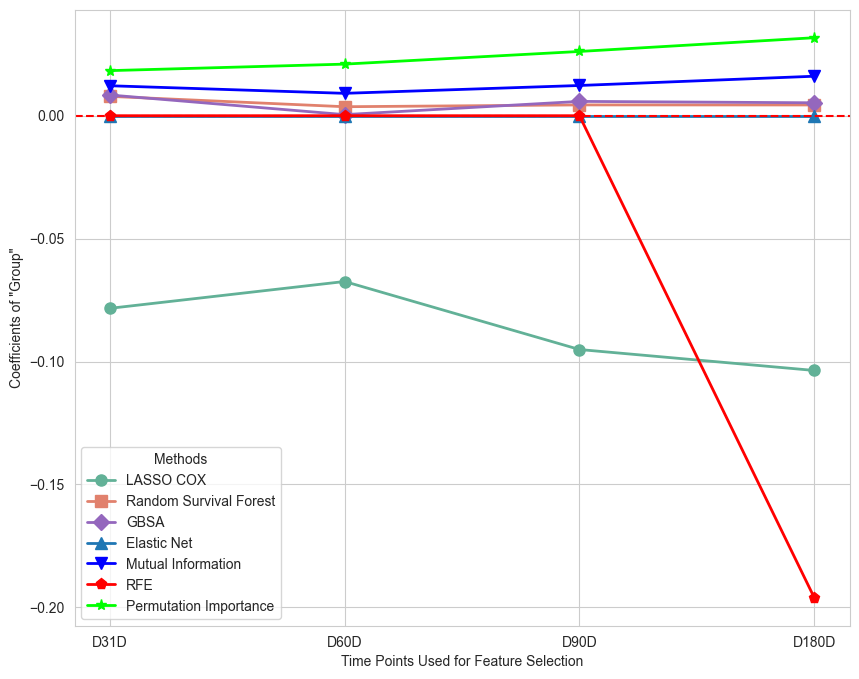

In [11]:
import matplotlib.pyplot as plt

# 创建一个包含8种颜色和标记的列表
colors = ["#62B197", "#E1816D", "#9467BD", "#1F77B4", "#0000FF", "#FF0000", "#00FF00",]
markers = ['o', 's', 'D', '^', 'v', 'p', '*',]

# 转置DataFrame
results_transposed = results.T

# 创建线形图
plt.figure(figsize=(10, 8))

# 遍历每一列（即每一种特征选择方法）
for i, method in enumerate(results_transposed.columns):
    plt.plot(results_transposed.index, results_transposed[method], label=method, color=colors[i], linewidth=2, marker=markers[i], markersize=8)

# 设置x轴和y轴的标签
plt.xlabel('Time Points Used for Feature Selection')
plt.ylabel('Coefficients of "Group"')

# 添加水平的0刻度线
plt.axhline(0, color='r', linestyle='--')

# 添加图例，并设置图例的位置
plt.legend(title='Methods', loc='best')

# 显示图形
plt.show()

In [12]:
import pandas as pd
# 读取C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xls
df1 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='LASSO COX')
df2 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='Random Survival Forest')
df3 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='GBSA')
df4 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='Elastic Net')
df5 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='Mutual Information')
df6 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='RFE')
df7 = pd.read_excel('C:/MyProject/MIMIC-IPE/results/sur特征/特征重要性sur.xlsx', sheet_name='Permutation Importance')

# Unnamed: 0列重命名为Feature
df1.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df2.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df3.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df4.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df5.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df6.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)
df7.rename(columns={'Unnamed: 0':'Feature'}, inplace=True)

# 5个df均设置Feature列为索引
df1.set_index('Feature', inplace=True)
df2.set_index('Feature', inplace=True)
df3.set_index('Feature', inplace=True)
df4.set_index('Feature', inplace=True)
df5.set_index('Feature', inplace=True)
df6.set_index('Feature', inplace=True)
df7.set_index('Feature', inplace=True)


# 更改每个df中列名，y1改为D31D、y2改为D60D、y3改为D90D、y4改为D180D
df1.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df2.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df3.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df4.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df5.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df6.columns = ['D31D', 'D60D', 'D90D', 'D180D']
df7.columns = ['D31D', 'D60D', 'D90D', 'D180D']



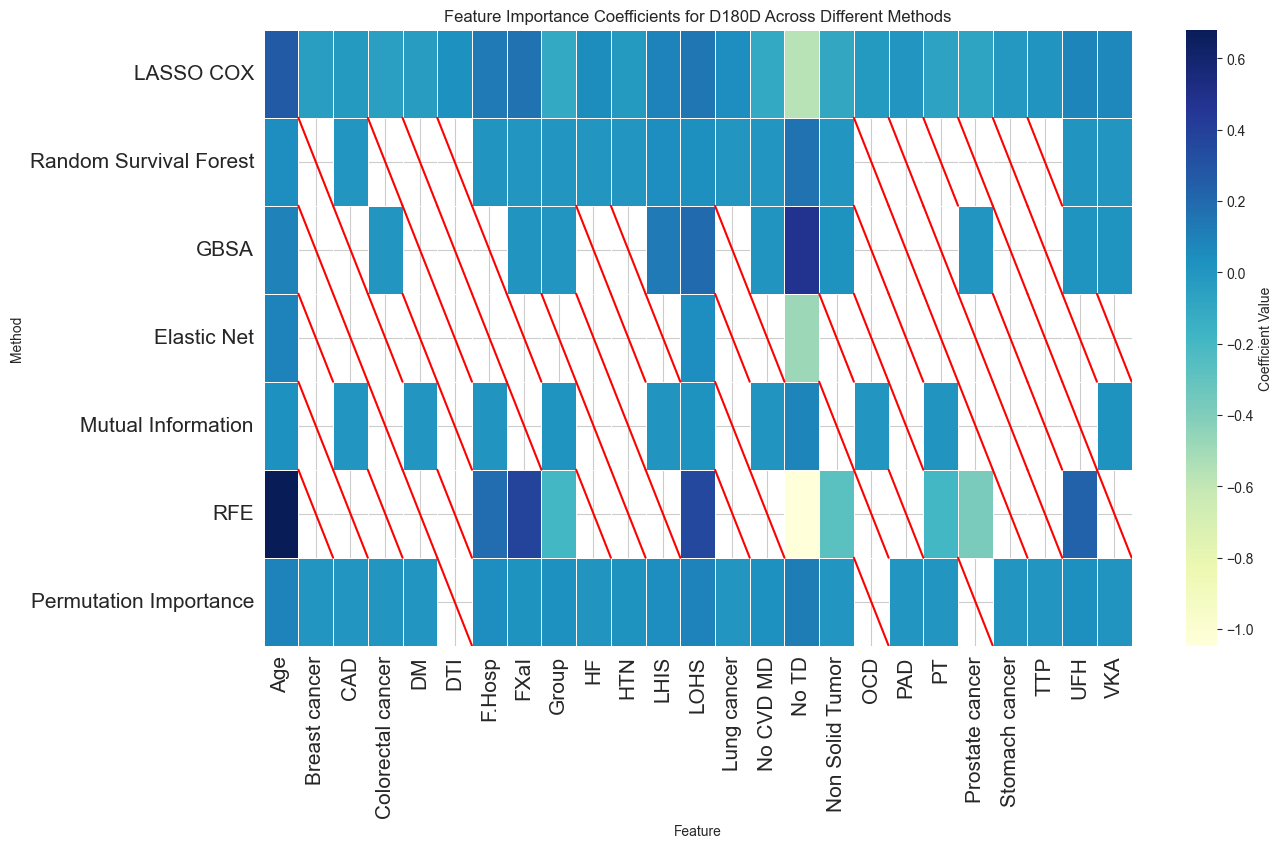

In [13]:
# 从8个df中保留D180D列，将这些列合并成一个新的df，列名为之前df的sheet名
# 创建一个空的DataFrame
D180D_df = pd.DataFrame()

# DataFrame列表和对应的名称
df_list = [df1, df2, df3, df4, df5, df6, df7]
df_names = ['LASSO COX', 'Random Survival Forest', 'GBSA', 'Elastic Net', 'Mutual Information', 'RFE', 'Permutation Importance']

# 遍历DataFrame列表
for df, name in zip(df_list, df_names):
    # 从每个DataFrame中取出'D180D'列的值
    D180D_values = df['D180D']
    # 将这些值添加到新的DataFrame中
    D180D_df[name] = D180D_values


import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np

# D180D_df只保留1位小数
D180D_df = D180D_df.round(4)

# Replace 0 values with NaN
D180D_df.replace(0, np.nan, inplace=True)

# Transpose the DataFrame for better visualization
D180D_combined_df_t = D180D_df.transpose()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(D180D_combined_df_t, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Coefficient Value'}, annot_kws={'size': 15}, linewidths=.5, ax=ax)

# Draw a red line on NaN cells
for i in range(D180D_combined_df_t.shape[0]):
    for j in range(D180D_combined_df_t.shape[1]):
        if np.isnan(D180D_combined_df_t.iloc[i, j]):
            ax.add_line(Line2D([j, j+1], [i, i+1], color='red'))

# Set plot labels and title
plt.title('Feature Importance Coefficients for D180D Across Different Methods')
plt.xlabel('Feature')
plt.ylabel('Method')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust the font size of the axis labels
plt.tick_params(axis='both', labelsize=15)

plt.show()

Top 10 features based on relative closeness:
['Age', 'LOHS', 'No TD', 'Group', 'FXaI', 'UFH', 'F.Hosp', 'LHIS', 'VKA', 'No CVD MD', 'Non Solid Tumor', 'CAD']


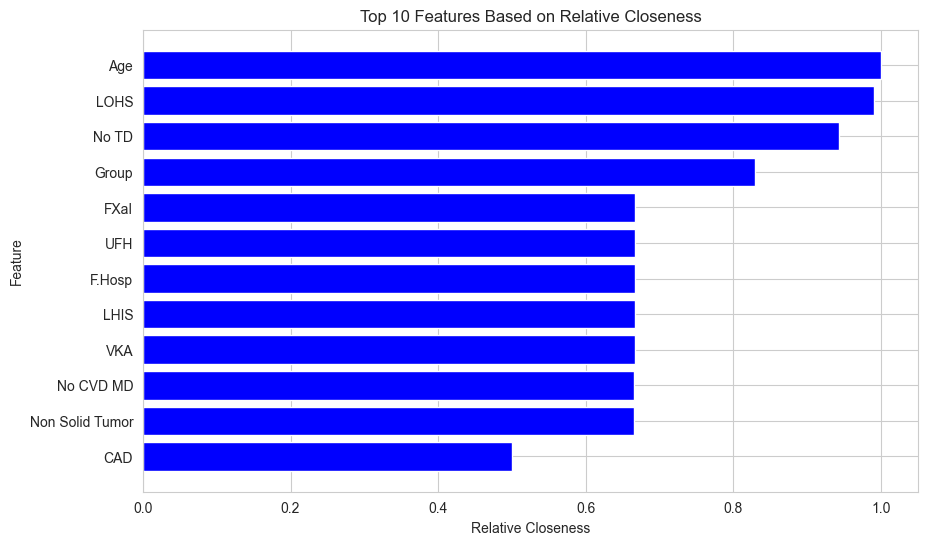

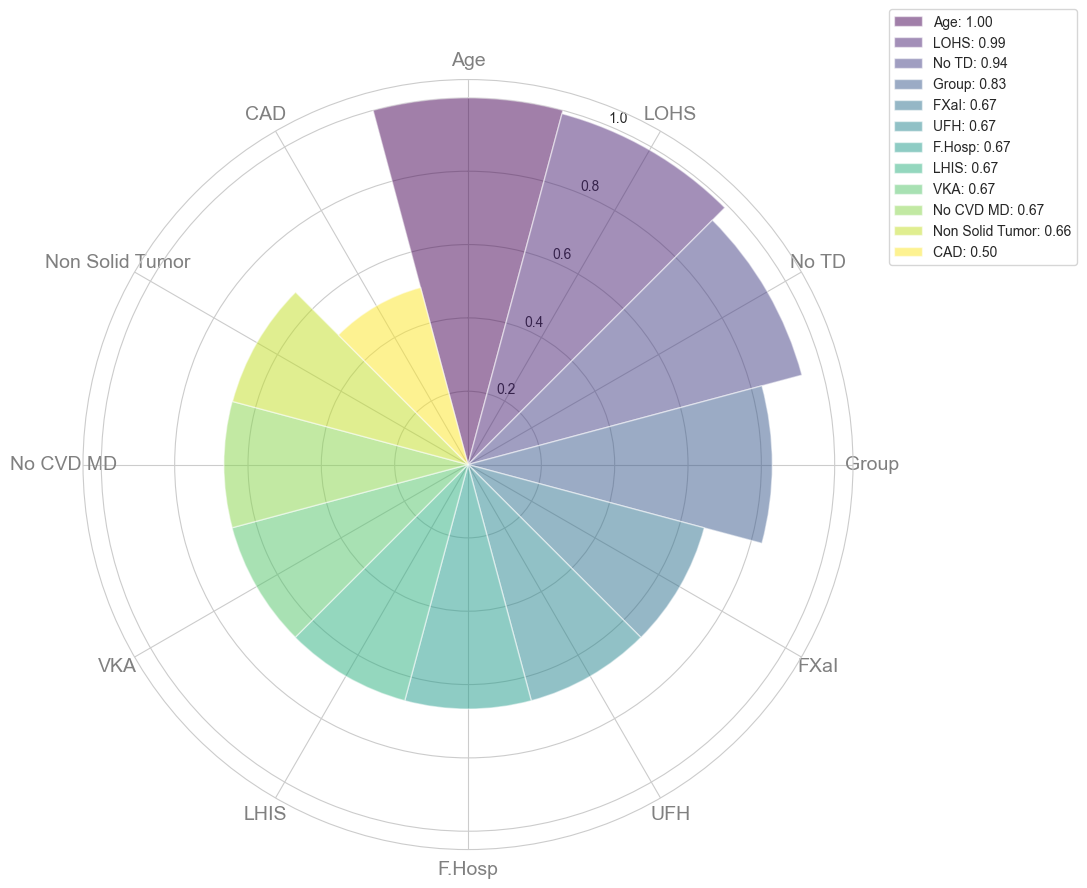

In [14]:
topsis_df = pd.DataFrame()
# 计算每个特征的均值系数
topsis_df['mean_coef'] = D180D_df.mean(axis=1)

# 计算特征被选中的次数
topsis_df['selected_count'] = D180D_df.notna().sum(axis=1)


import numpy as np
# 1. 计算特征的均值系数
# 将每个特征在5种特征选择方法中的系数绝对值相加，然后除以5，获得均值。
# 1. 使用原始的 mean_coef 和标准化的 selected_count
topsis_df['selected_count_norm'] = topsis_df['selected_count']
#/ np.sqrt((topsis_df['selected_count'] ** 2).sum()))

# 2. 理想解和反理想解
ideal_solution = [topsis_df['mean_coef'].max(), topsis_df['selected_count_norm'].max()]
anti_ideal_solution = [topsis_df['mean_coef'].min(), topsis_df['selected_count_norm'].min()]

# 3. 计算每个特征到理想解和反理想解的距离
topsis_df['distance_to_ideal'] = np.sqrt((topsis_df['mean_coef'] - ideal_solution[0]) ** 2 + (topsis_df['selected_count_norm'] - ideal_solution[1]) ** 2)
topsis_df['distance_to_anti_ideal'] = np.sqrt((topsis_df['mean_coef'] - anti_ideal_solution[0]) ** 2 + (topsis_df['selected_count_norm'] - anti_ideal_solution[1]) ** 2)
# 4. 计算相对接近度
topsis_df['relative_closeness'] = topsis_df['distance_to_anti_ideal'] / (topsis_df['distance_to_ideal'] + topsis_df['distance_to_anti_ideal'])

# 5. 根据相对接近度从大到小排序
topsis_df_sorted = topsis_df.sort_values(by='relative_closeness', ascending=False)

# 选择前10个特征
top_10_features = topsis_df_sorted.head(12).index.tolist()

# 打印结果
print("Top 10 features based on relative closeness:")
print(top_10_features)

import matplotlib.pyplot as plt

# 假设 topsis_df_sorted 是按照 relative_closeness 排序的 DataFrame

# 创建一个新的 DataFrame，只包含 relative_closeness 最高的前10个特征
top_10_relative_closeness = topsis_df_sorted['relative_closeness'].head(12)

# 创建水平条形图
plt.figure(figsize=(10, 6))
plt.barh(top_10_relative_closeness.index, top_10_relative_closeness.values, color='blue')
plt.xlabel('Relative Closeness')
plt.ylabel('Feature')
plt.title('Top 10 Features Based on Relative Closeness')
plt.gca().invert_yaxis()  # Invert y axis to have the feature with the highest relative closeness at the top
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置学术风格配色
sns.set_style("whitegrid")

# 提取前10个特征的'relative_closeness'数据
top_10_features_df = topsis_df_sorted[['relative_closeness']].head(12)

# 设置每个特征的角度为相等的
angles = np.linspace(0, 2 * np.pi, len(top_10_features_df), endpoint=False)

# 计算每个扇形的半径
radii = top_10_features_df['relative_closeness'].values

# 创建南丁格尔玫瑰图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# 创建颜色列表
colors = plt.cm.viridis(np.linspace(0, 1, len(angles)))

# 绘制每个扇面
for i in range(len(angles)):
    ax.bar(angles[i], radii[i], width=2 * np.pi / len(top_10_features_df), color=colors[i], alpha=0.5)

# 设置图形的角度
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# 添加特征标签
ax.set_xticks(angles)
ax.set_xticklabels(top_10_features_df.index, color='grey', size=14)

# 添加图例
legend_labels = [f"{feature}: {radius:.2f}" for feature, radius in zip(top_10_features_df.index, radii)]
ax.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 添加标题
# plt.title('Nightingale Rose Chart of Top 10 Features Based on Relative Closeness', size=20, color='blue', y=1.1)

# 显示图表
plt.show()

In [15]:
from sklearn.preprocessing import MinMaxScaler

# 创建一个MinMaxScaler对象
scaler = MinMaxScaler()

# 使用MinMaxScaler对象来归一化数据，并保留原始的索引
df1 = pd.DataFrame(scaler.fit_transform(df1), columns=df1.columns, index=df1.index)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns, index=df2.index)
df3 = pd.DataFrame(scaler.fit_transform(df3), columns=df3.columns, index=df3.index)
df4 = pd.DataFrame(scaler.fit_transform(df4), columns=df4.columns, index=df4.index)
df5 = pd.DataFrame(scaler.fit_transform(df5), columns=df5.columns, index=df5.index)
df6 = pd.DataFrame(scaler.fit_transform(df6), columns=df6.columns, index=df6.index)
df7 = pd.DataFrame(scaler.fit_transform(df7), columns=df7.columns, index=df7.index)



In [16]:
# 从8个df中取出Group行的特征值，然后拼接成一个新的df，新df的列是之前df的sheet名
# 创建一个空的DataFrame
group_df = pd.DataFrame()

# DataFrame列表和对应的名称
df_list = [df1, df2, df3, df4, df5, df6, df7]
df_names = ['LASSO COX', 'Random Survival Forest', 'GBSA', 'Elastic Net', 'Mutual Information', 'RFE', 'Permutation Importance']

# 遍历DataFrame列表
for df, name in zip(df_list, df_names):
    # 从每个DataFrame中取出'Group'行的值
    group_values = df.loc['Group']
    # 将这些值添加到新的DataFrame中
    group_df[name] = group_values

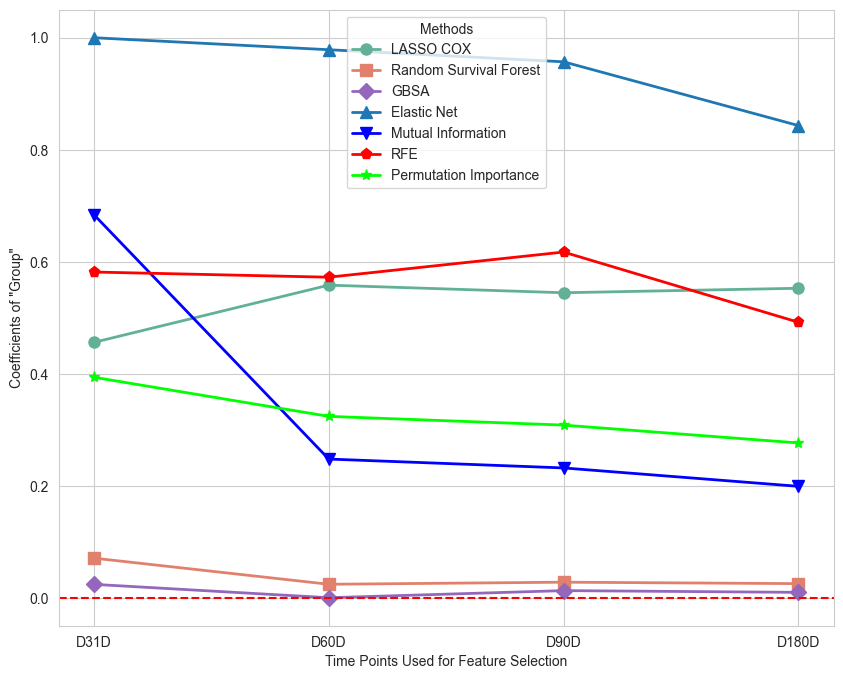

In [17]:
import matplotlib.pyplot as plt

# 创建一个包含8种颜色和标记的列表
colors = ["#62B197", "#E1816D", "#9467BD", "#1F77B4", "#0000FF", "#FF0000", "#00FF00", "#0000FF"]
markers = ['o', 's', 'D', '^', 'v', 'p', '*',]

# 转置DataFrame
results_transposed = group_df

# 创建线形图
plt.figure(figsize=(10, 8))

# 遍历每一列（即每一种特征选择方法）
for i, method in enumerate(results_transposed.columns):
    plt.plot(results_transposed.index, results_transposed[method], label=method, color=colors[i], linewidth=2, marker=markers[i], markersize=8)

# 设置x轴和y轴的标签
plt.xlabel('Time Points Used for Feature Selection')
plt.ylabel('Coefficients of "Group"')

# 添加水平的0刻度线
plt.axhline(0, color='r', linestyle='--')

# 添加图例，并设置图例的位置
plt.legend(title='Methods', loc='best')

# 显示图形
plt.show()

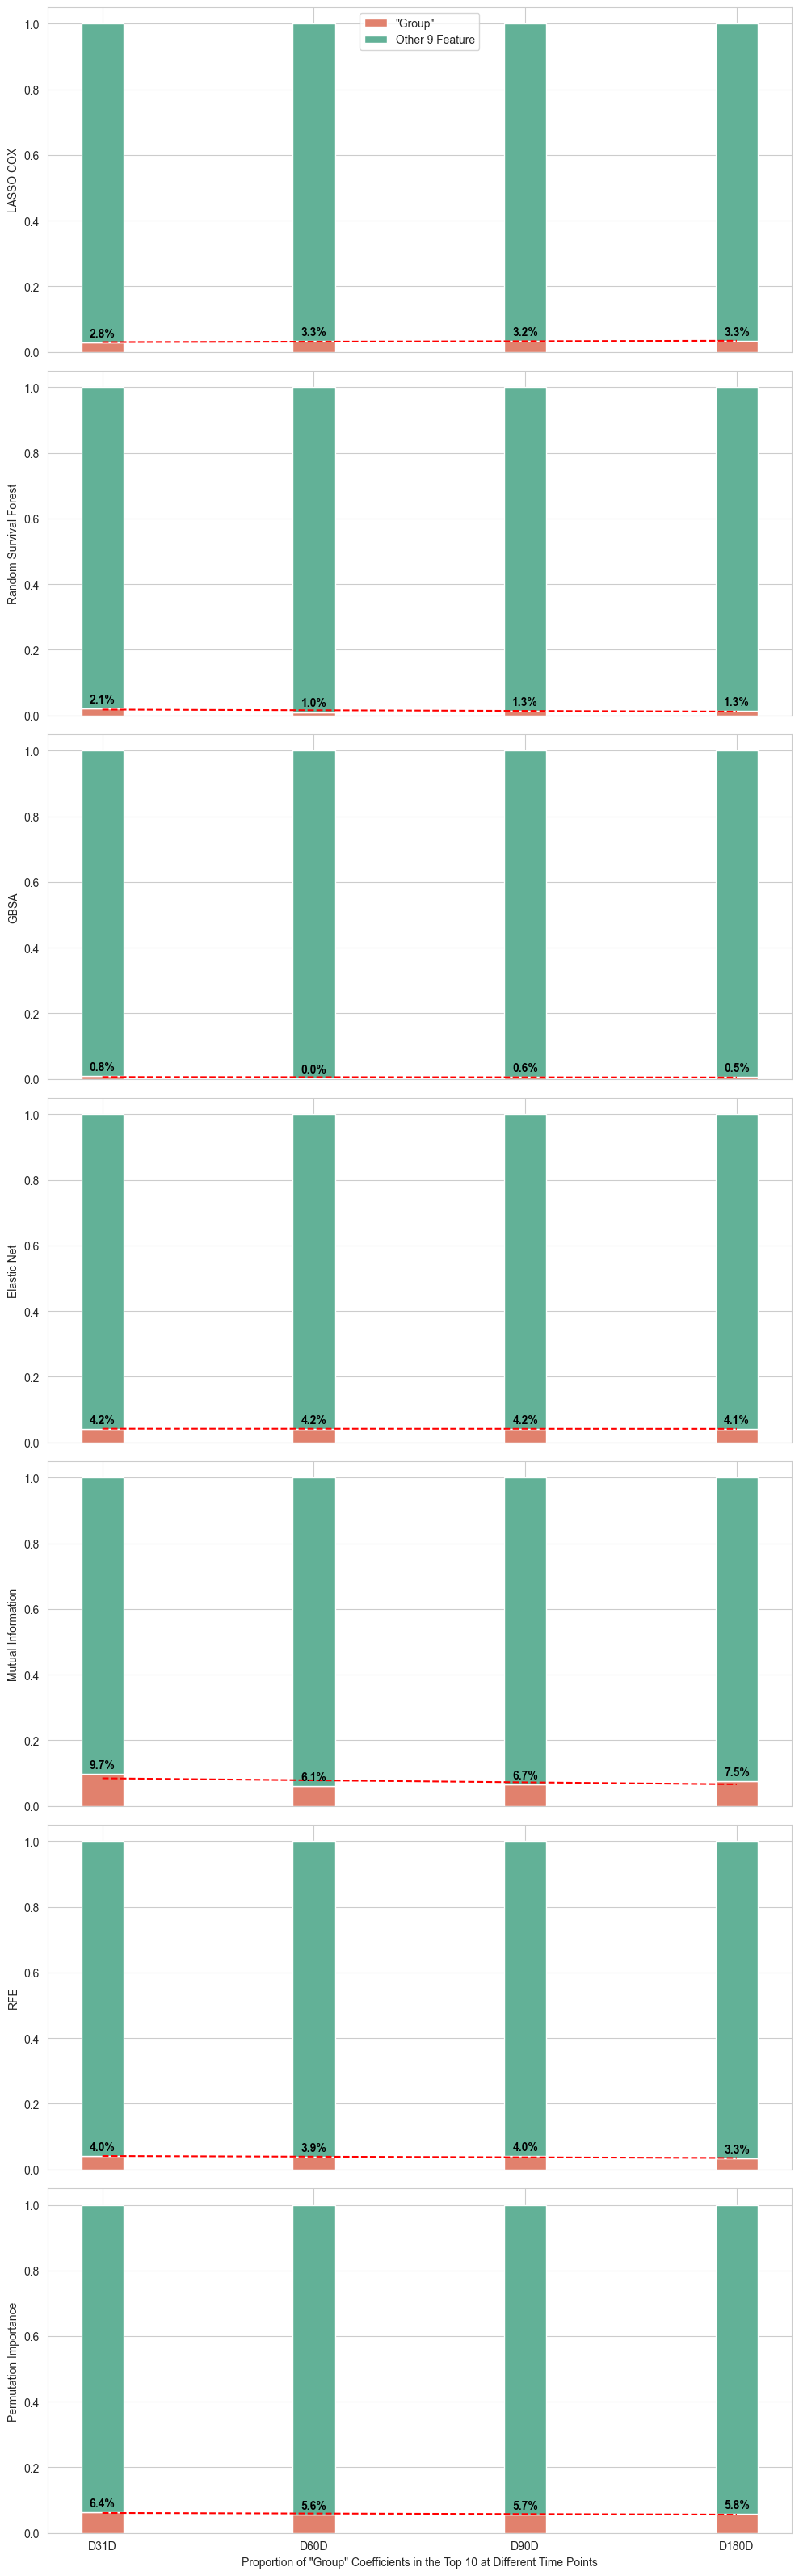

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# 创建一个大的画布，调整figsize参数使子图更扁，并设置sharex=True使所有子图共享x轴
fig, axs = plt.subplots(7, 1, figsize=(10, 32), sharex=True)

# 数据框列表
dfs = [df1, df2, df3, df4, df5, df6, df7]
# 罗列出所使用的特征选择方法
methods = ['LASSO COX', 'Random Survival Forest', 'GBSA', 'Elastic Net', 'Mutual Information', 'RFE', 'Permutation Importance',]

for i, df in enumerate(dfs):
    # 取绝对值
    df = df.abs()
    # 计算每一列的非空值的和
    column_sums = df.sum()

    # 找到"Group"行的值
    group_values = df.loc['Group']
    
    # 取绝对值
    # group_values = group_values.abs()

    # 计算"Group"行的值在总和中的占比
    group_percentages = group_values / column_sums

    # 计算其余所有非空行值的占比
    other_values = df.drop('Group')
    other_percentages = other_values.sum() / column_sums

    # 创建堆叠条形图
    N = len(df.columns)
    ind = np.arange(N)
    width = 0.2  # 更窄的柱子

    # 交换柱子的颜色
    p1 = axs[i].bar(ind, group_percentages, width, color='#E1816D')
    p2 = axs[i].bar(ind, other_percentages, width, bottom=group_percentages, color='#62B197')

    # 在每个柱子上添加数字标签
    for j, v in enumerate(group_percentages):
        # 颜色使用黑色
        axs[i].text(j, v + 0.01, f'{v*100:.1f}%', color='black', ha='center', va='bottom', fontweight='bold')

    # 修改横轴的标题
    axs[i].set_ylabel(f'{methods[i]}')  # 只包含特征选择方法的名称

    axs[i].set_xticks(ind)
    axs[i].set_xticklabels(df.columns)

    # 只在第一个子图中添加图例
    if i == 0:
        axs[i].legend((p1[0], p2[0]), ('"Group"', 'Other 9 Feature'))

    # 计算趋势线
    z = np.polyfit(ind, group_percentages, 1)
    p = np.poly1d(z)

    # 添加趋势线到图表
    axs[i].plot(ind, p(ind), 'r--')

# 在最后一个子图上设置x轴的标题
axs[-1].set_xlabel('Proportion of "Group" Coefficients in the Top 10 at Different Time Points')

plt.tight_layout()
plt.show()

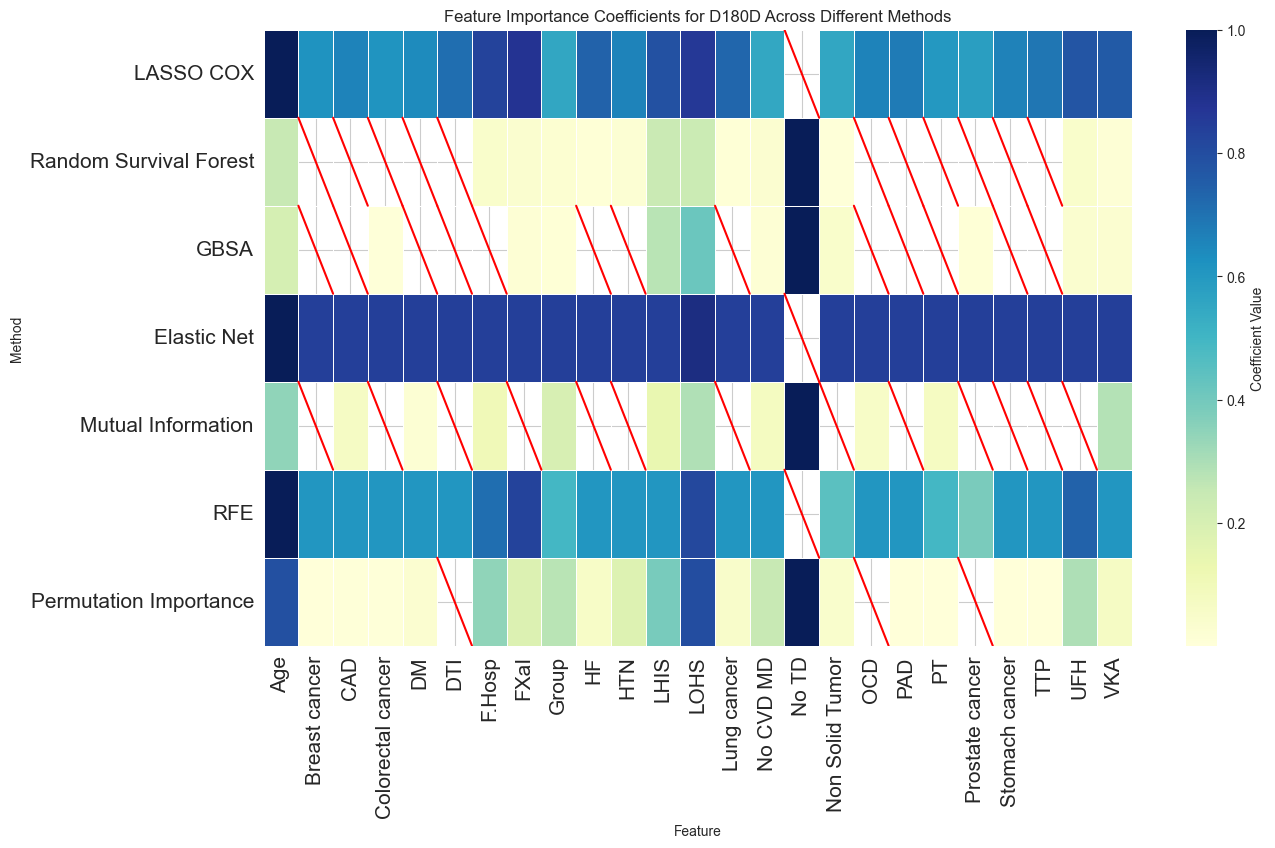

In [20]:
# 从8个df中保留D180D列，将这些列合并成一个新的df，列名为之前df的sheet名
# 创建一个空的DataFrame
D180D_df = pd.DataFrame()

# DataFrame列表和对应的名称
df_list = [df1, df2, df3, df4, df5, df6, df7]
df_names = ['LASSO COX', 'Random Survival Forest', 'GBSA', 'Elastic Net', 'Mutual Information', 'RFE', 'Permutation Importance']

# 遍历DataFrame列表
for df, name in zip(df_list, df_names):
    # 从每个DataFrame中取出'D180D'列的值
    D180D_values = df['D180D']
    # 将这些值添加到新的DataFrame中
    D180D_df[name] = D180D_values
    
    
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D
import numpy as np

# D180D_df只保留1位小数
D180D_df = D180D_df.round(3)

# Replace 0 values with NaN
D180D_df.replace(0, np.nan, inplace=True)

# Transpose the DataFrame for better visualization
D180D_combined_df_t = D180D_df.transpose()

# Plot the data
fig, ax = plt.subplots(figsize=(14, 8))
sns.heatmap(D180D_combined_df_t, annot=False, cmap="YlGnBu", cbar_kws={'label': 'Coefficient Value'}, annot_kws={'size': 15}, linewidths=.5, ax=ax)

# Draw a red line on NaN cells
for i in range(D180D_combined_df_t.shape[0]):
    for j in range(D180D_combined_df_t.shape[1]):
        if np.isnan(D180D_combined_df_t.iloc[i, j]):
            ax.add_line(Line2D([j, j+1], [i, i+1], color='red'))

# Set plot labels and title
plt.title('Feature Importance Coefficients for D180D Across Different Methods')
plt.xlabel('Feature')
plt.ylabel('Method')

# Rotate x-axis labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

# Adjust the font size of the axis labels
plt.tick_params(axis='both', labelsize=15)

plt.show()

方法二：TOPSIS法
标准化特征的均值系数和被选中次数。
计算每个特征到理想解（最高值）和反理想解（最低值）的距离。
根据距离计算每个特征的相对接近度，值越大越好。
TOPSIS法（Technique for Order Preference by Similarity to Ideal Solution）是一种多准则决策方法，其核心思想是通过比较各备选方案与理想解和反理想解的相对距离来进行排序和选择。具体而言，TOPSIS法首先对各指标进行标准化处理，以消除量纲的影响；然后计算每个备选方案到理想解和反理想解的欧几里得距离；最后，通过计算各方案相对于理想解的相对接近度，得到综合评价值，从而对各方案进行排序。TOPSIS法的优势在于其简明易懂，能够同时考虑各指标的最优和最差情况，且不需要对指标权重进行显式分配，适用于多种决策场景中的综合评价和优选问题。

Top 10 features based on relative closeness:
['Age', 'LOHS', 'LHIS', 'VKA', 'Group', 'No CVD MD', 'F.Hosp', 'FXaI', 'UFH', 'Non Solid Tumor', 'HTN', 'HF']


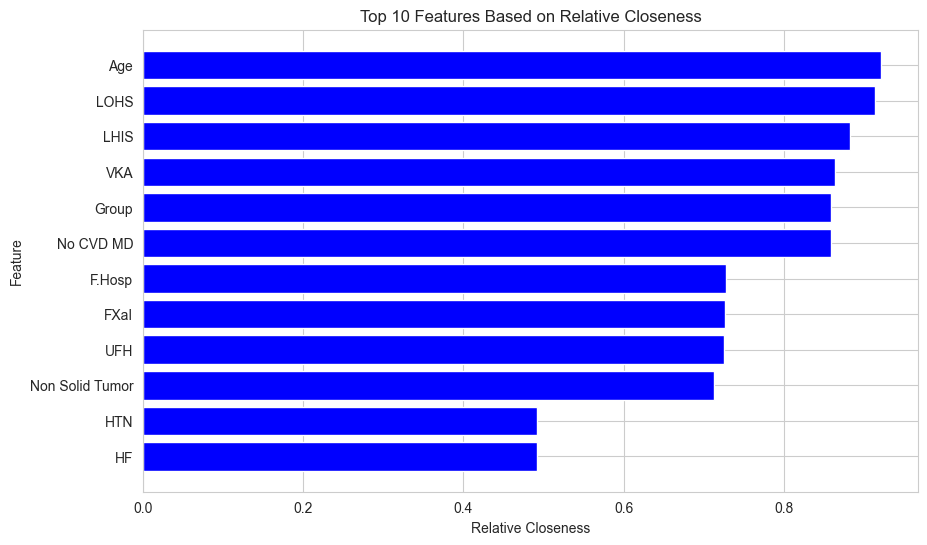

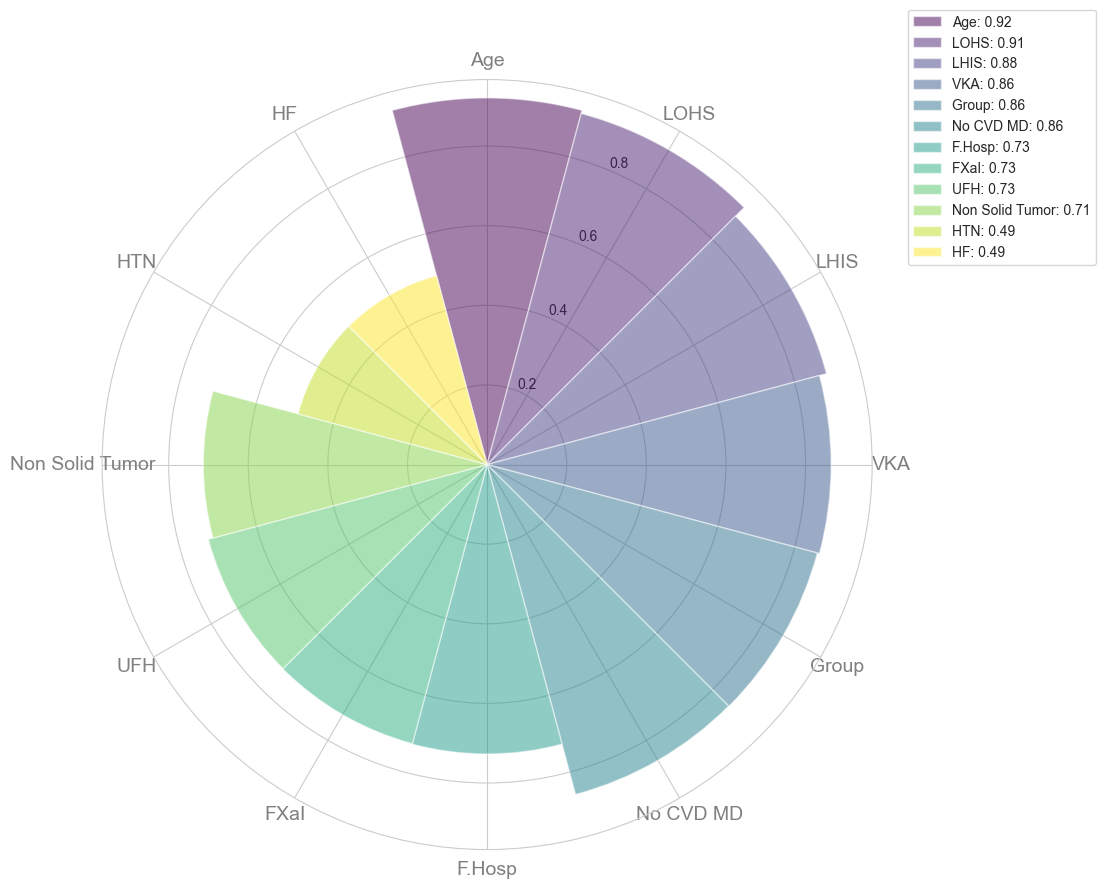

In [21]:
topsis_df = pd.DataFrame()
# 计算每个特征的均值系数
topsis_df['mean_coef'] = D180D_df.mean(axis=1)

# 计算特征被选中的次数
topsis_df['selected_count'] = D180D_df.notna().sum(axis=1)


import numpy as np
# 1. 计算特征的均值系数
# 将每个特征在5种特征选择方法中的系数绝对值相加，然后除以5，获得均值。
# 1. 使用原始的 mean_coef 和标准化的 selected_count
topsis_df['selected_count_norm'] = topsis_df['selected_count'] 
#/ np.sqrt((topsis_df['selected_count'] ** 2).sum()))

# 2. 理想解和反理想解
ideal_solution = [topsis_df['mean_coef'].max(), topsis_df['selected_count_norm'].max()]
anti_ideal_solution = [topsis_df['mean_coef'].min(), topsis_df['selected_count_norm'].min()]

# 3. 计算每个特征到理想解和反理想解的距离
topsis_df['distance_to_ideal'] = np.sqrt((topsis_df['mean_coef'] - ideal_solution[0]) ** 2 + (topsis_df['selected_count_norm'] - ideal_solution[1]) ** 2)
topsis_df['distance_to_anti_ideal'] = np.sqrt((topsis_df['mean_coef'] - anti_ideal_solution[0]) ** 2 + (topsis_df['selected_count_norm'] - anti_ideal_solution[1]) ** 2)
# 4. 计算相对接近度
topsis_df['relative_closeness'] = topsis_df['distance_to_anti_ideal'] / (topsis_df['distance_to_ideal'] + topsis_df['distance_to_anti_ideal'])

# 5. 根据相对接近度从大到小排序
topsis_df_sorted = topsis_df.sort_values(by='relative_closeness', ascending=False)

# 选择前10个特征
top_10_features = topsis_df_sorted.head(12).index.tolist()

# 打印结果
print("Top 10 features based on relative closeness:")
print(top_10_features)

import matplotlib.pyplot as plt

# 假设 topsis_df_sorted 是按照 relative_closeness 排序的 DataFrame

# 创建一个新的 DataFrame，只包含 relative_closeness 最高的前10个特征
top_10_relative_closeness = topsis_df_sorted['relative_closeness'].head(12)

# 创建水平条形图
plt.figure(figsize=(10, 6))
plt.barh(top_10_relative_closeness.index, top_10_relative_closeness.values, color='blue')
plt.xlabel('Relative Closeness')
plt.ylabel('Feature')
plt.title('Top 10 Features Based on Relative Closeness')
plt.gca().invert_yaxis()  # Invert y axis to have the feature with the highest relative closeness at the top
plt.show()

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# 设置学术风格配色
sns.set_style("whitegrid")

# 提取前10个特征的'relative_closeness'数据
top_10_features_df = topsis_df_sorted[['relative_closeness']].head(12)

# 设置每个特征的角度为相等的
angles = np.linspace(0, 2 * np.pi, len(top_10_features_df), endpoint=False)

# 计算每个扇形的半径
radii = top_10_features_df['relative_closeness'].values

# 创建南丁格尔玫瑰图
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# 创建颜色列表
colors = plt.cm.viridis(np.linspace(0, 1, len(angles)))

# 绘制每个扇面
for i in range(len(angles)):
    ax.bar(angles[i], radii[i], width=2 * np.pi / len(top_10_features_df), color=colors[i], alpha=0.5)

# 设置图形的角度
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# 添加特征标签
ax.set_xticks(angles)
ax.set_xticklabels(top_10_features_df.index, color='grey', size=14)

# 添加图例
legend_labels = [f"{feature}: {radius:.2f}" for feature, radius in zip(top_10_features_df.index, radii)]
ax.legend(legend_labels, loc='upper right', bbox_to_anchor=(1.3, 1.1))

# 添加标题
# plt.title('Nightingale Rose Chart of Top 10 Features Based on Relative Closeness', size=20, color='blue', y=1.1)

# 显示图表
plt.show()